In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

In [3]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False) 
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

In [4]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
 
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index 
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [5]:
# import statsmodels base api module for the data
import statsmodels.api as sm
co2_data = sm.datasets.co2.load_pandas()
df = co2_data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


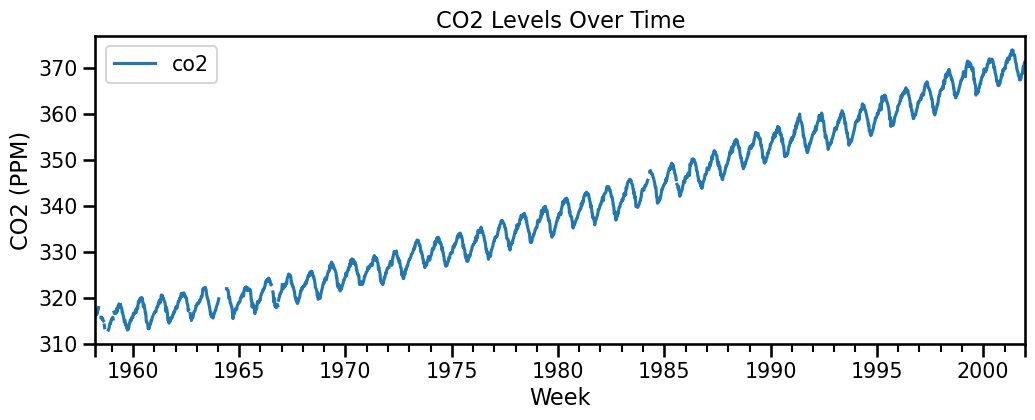

In [6]:
# Visualize the data
ax = df.plot()
ax.set(ylabel="CO2 (PPM)", xlabel="Week", title="CO2 Levels Over Time");

In [7]:
# Check for null values
df.isna().sum()

co2    59
dtype: int64

In [8]:
# Impute null values
df = df.interpolate()
df.isna().sum()

co2    0
dtype: int64

In [9]:
# create a t-1 column
# Let's add a column with the values from the previous week (one lag)
df["t-1"] = df["co2"].shift(1)
df.head()

,co2,t-1
1958-03-29,316.1,NaN
1958-04-05,317.3,316.1
1958-04-12,317.6,317.3
1958-04-19,317.5,317.6
1958-04-26,316.4,317.5


In [10]:
# Loop to add columns with lags 1-4
for i in range(1, 5):
    df[f"t-{i}"] = df["co2"].shift(i)
df

,co2,t-1,t-2,t-3,t-4
1958-03-29,316.1,NaN,NaN,NaN,NaN
1958-04-05,317.3,316.1,NaN,NaN,NaN
1958-04-12,317.6,317.3,316.1,NaN,NaN
1958-04-19,317.5,317.6,317.3,316.1,NaN
1958-04-26,316.4,317.5,317.6,317.3,316.1
...,...,...,...,...,...
2001-12-01,370.3,370.3,369.7,368.8,368.7
2001-12-08,370.8,370.3,370.3,369.7,368.8
2001-12-15,371.2,370.8,370.3,370.3,369.7
2001-12-22,371.3,371.2,370.8,370.3,370.3


In [11]:
# Dropping early rows with NA values
df_model = df.dropna()
df_model

,co2,t-1,t-2,t-3,t-4
1958-04-26,316.4,317.5,317.6,317.3,316.1
1958-05-03,316.9,316.4,317.5,317.6,317.3
1958-05-10,317.2,316.9,316.4,317.5,317.6
1958-05-17,317.5,317.2,316.9,316.4,317.5
1958-05-24,317.9,317.5,317.2,316.9,316.4
...,...,...,...,...,...
2001-12-01,370.3,370.3,369.7,368.8,368.7
2001-12-08,370.8,370.3,370.3,369.7,368.8
2001-12-15,371.2,370.8,370.3,370.3,369.7
2001-12-22,371.3,371.2,370.8,370.3,370.3


In [12]:
# Our target is co2, the actual value for that rows' date
y = df_model["co2"]
X = df_model.drop(columns="co2")
X

,t-1,t-2,t-3,t-4
1958-04-26,317.5,317.6,317.3,316.1
1958-05-03,316.4,317.5,317.6,317.3
1958-05-10,316.9,316.4,317.5,317.6
1958-05-17,317.2,316.9,316.4,317.5
1958-05-24,317.5,317.2,316.9,316.4
...,...,...,...,...
2001-12-01,370.3,369.7,368.8,368.7
2001-12-08,370.3,370.3,369.7,368.8
2001-12-15,370.8,370.3,370.3,369.7
2001-12-22,371.2,370.8,370.3,370.3


In [13]:
# VALIDATION SPLIT FOR TIME SERIES
# calculating integer index for 75%/25% split
idx_split = round(len(X) * 0.75)
idx_split

1710

In [14]:
# What date corresponds to 75%?
split_date = X.index[idx_split]
split_date

Timestamp('1991-02-02 00:00:00', freq='W-SAT')

In [15]:
# Time Series train-test-split
# All data before split date is training
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]
# All data after split date is testing
X_test = X.loc[split_date:]
y_test = y.loc[split_date:]

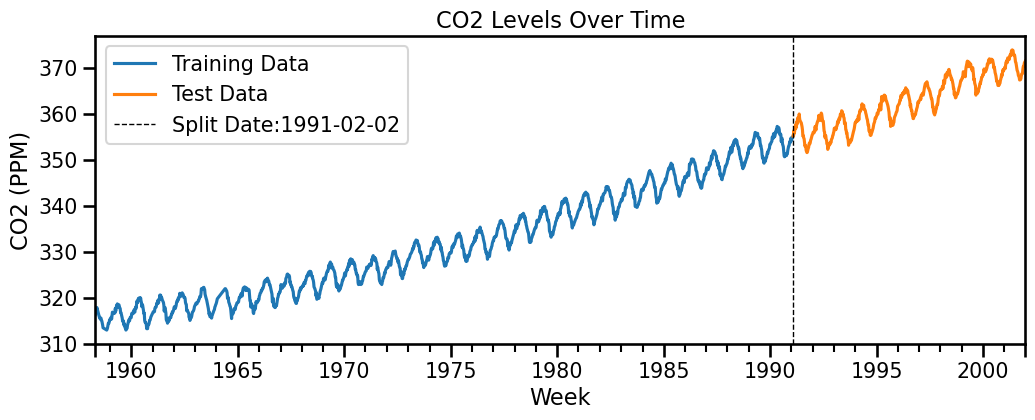

In [16]:
# Plotting the training and test data
ax = y_train.plot(label="Training Data")
y_test.plot(ax=ax, label="Test Data")
# Saving the date as a string for matplotlib
split_date_str = split_date.strftime("%Y-%m-%d")
# Annotating the split data
ax.axvline(
    split_date_str, color="black", ls="--", lw=1.0, label=f"Split Date:{split_date_str}"
)
ax.set(ylabel="CO2 (PPM)", xlabel="Week", title="CO2 Levels Over Time")
ax.legend();

In [17]:
# INSTANTIATE AND FIT THE MODEL
# Instantiate a Linear Regression Model
lin_reg = LinearRegression()
# Fit on the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

In [18]:
# Making a Series of our test predictions
y_pred_test = lin_reg.predict(X_test)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)
y_pred_test

1991-02-02    355.160974
1991-02-09    355.254278
1991-02-16    355.280741
1991-02-23    356.473156
1991-03-02    355.957149
                 ...    
2001-12-01    370.452759
2001-12-08    370.639149
2001-12-15    370.967720
2001-12-22    371.257917
2001-12-29    371.488852
Freq: W-SAT, Length: 570, dtype: float64

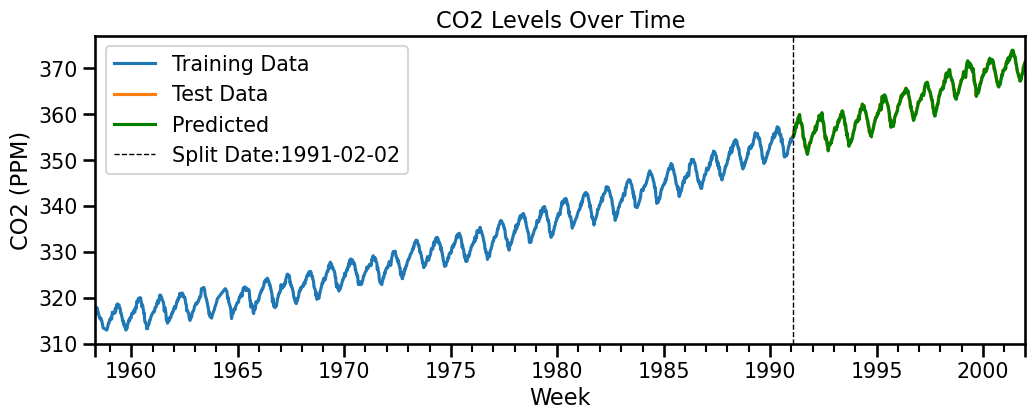

In [19]:
# Plotting the training and test data and predictions for test
ax = y_train.plot(label="Training Data")
y_test.plot(ax=ax, label="Test Data")
y_pred_test.plot(ax=ax, label="Predicted", color="green")
# Saving the date as a string for matplotlib
split_date_str = split_date.strftime("%Y-%m-%d")
# Annotating the split data
ax.axvline(
    split_date_str, color="black", ls="--", lw=1.0, label=f"Split Date:{split_date_str}"
)
ax.set(ylabel="CO2 (PPM)", xlabel="Week", title="CO2 Levels Over Time")
ax.legend();

In [20]:
# Getting predictions and metrics
evaluate_regression(lin_reg, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.344
- MSE = 0.198
- RMSE = 0.445
- R^2 = 0.999

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 0.381
- MSE = 0.239
- RMSE = 0.489
- R^2 = 0.992
